In [3]:
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from pathlib import Path

In [4]:
image_path = Path("Sugarcane Dataset")

Data Exploration

In [5]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 5 directories and 0 images in 'Sugarcane Dataset'.
There are 0 directories and 522 images in 'Sugarcane Dataset\Healthy'.
There are 0 directories and 462 images in 'Sugarcane Dataset\Mosaic'.
There are 0 directories and 518 images in 'Sugarcane Dataset\RedRot'.
There are 0 directories and 514 images in 'Sugarcane Dataset\Rust'.
There are 0 directories and 505 images in 'Sugarcane Dataset\Yellow'.


Random Image Path: Sugarcane Dataset\RedRot\redrot (276).jpeg
Image Class: RedRot
Image Height: 1600
Image Width: 758


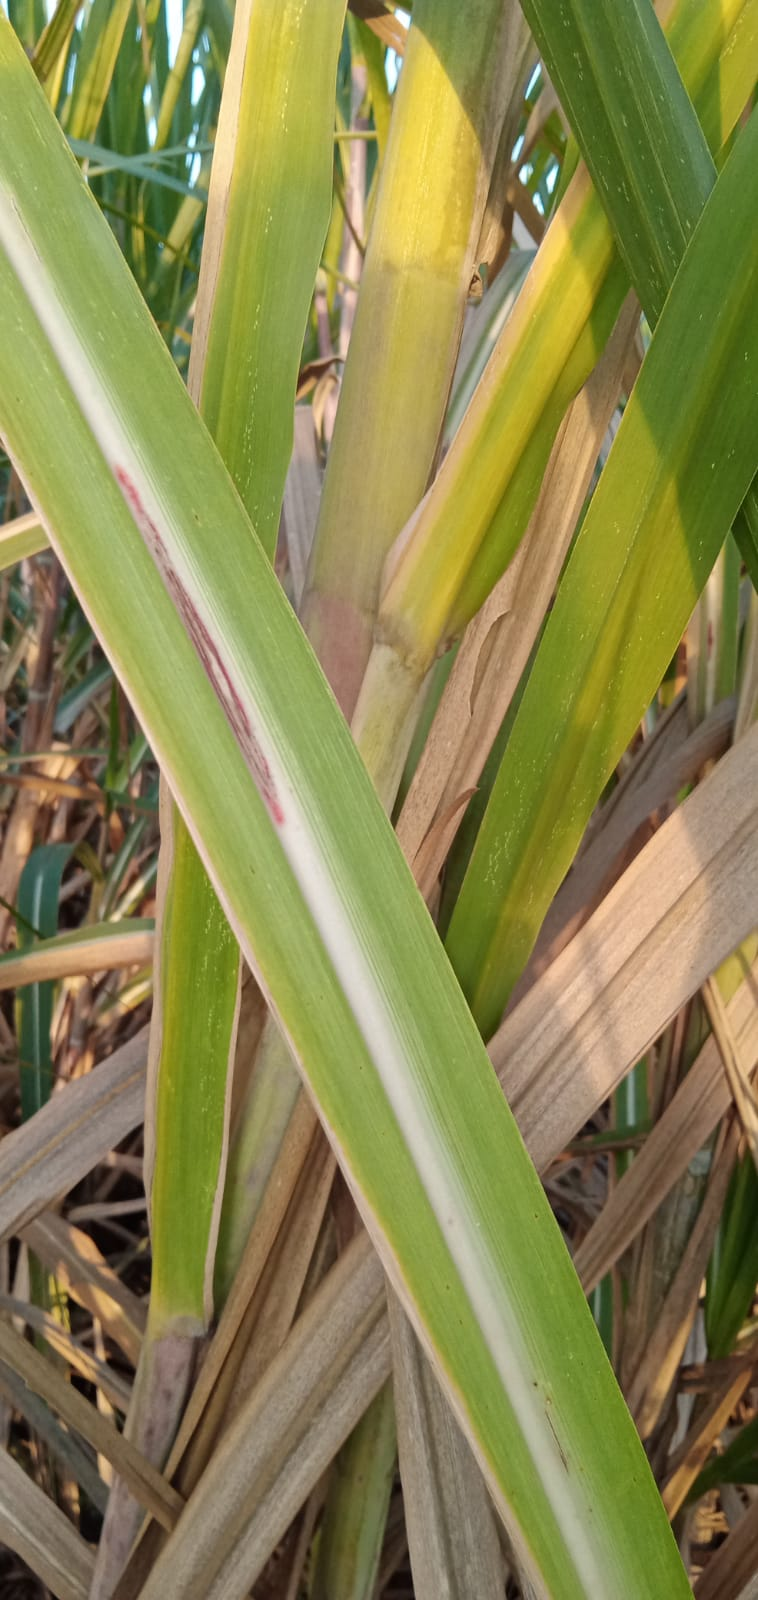

In [6]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*.jpeg"))

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

(-0.5, 757.5, 1599.5, -0.5)

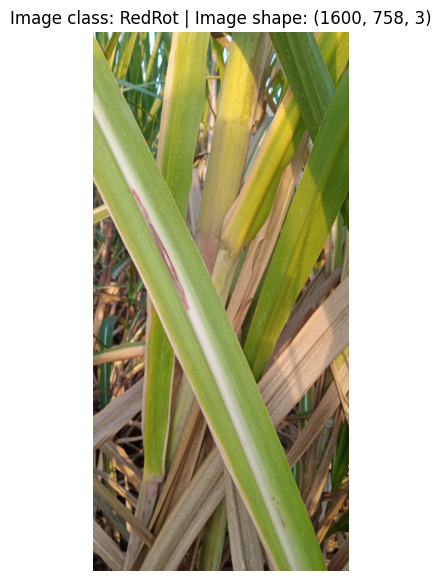

In [7]:
img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

Transforming Data


In [18]:
data_tansfrom = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [20]:
data_tansfrom(img).shape

torch.Size([3, 224, 224])

In [8]:
dataset = datasets.ImageFolder(root=image_path)
train_ratio = 0.8
test_ratio = 0.2

In [9]:
num_train = int(len(dataset) * train_ratio)
num_test = len(dataset) - num_train

In [10]:
train_dataset, test_dataset = random_split(dataset, [num_train, num_test])